In [0]:
!pip install wandb --upgrade
# !wandb login 

import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.utils import np_utils
# import wandb
# from wandb.keras import WandbCallback
import os
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

pacific_timezone = pytz.timezone("US/Pacific")
utc_timezone = pytz.timezone("UTC")

Requirement already up-to-date: wandb in /usr/local/lib/python3.6/dist-packages (0.8.30)
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [0]:
def draw_digit(digit, label=None):
  # Make those columns into a array of 8-bits pixels
  # This array will be of 1D with length 784
  # The pixel intensity values are integers from 0 to 255
  pixels = np.array(digit * 255, dtype='uint8')

  # Reshape the array into 28 x 28 array (2-dimensional array)
  pixels = pixels.reshape((28, 28))

  # Plot
  if label is not None:
    plt.title('Label is {label}'.format(label=label))
  plt.imshow(pixels, cmap='gray')
  plt.show()

In [0]:
# current_time = utc_timezone.localize(datetime.now()).astimezone(pacific_timezone).strftime("%H:%M:%S")
# run = wandb.init(project="Mnist", group="Ryan", name="Ryan - "+current_time)

# Normalize data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.astype('float32')
X_train = X_train / 255.0
X_test = X_test.astype('float32')
X_test = X_test / 255.0

# Get image height and width
img_height = X_train.shape[2]
img_width = X_train.shape[1]

# One-hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

num_classes = y_train.shape[1]



In [0]:
def create_model():
  model = Sequential()
  model.add(Flatten(input_shape=(img_width, img_height))) # Turn grid into array
  model.add(Dense(num_classes, activation="relu"))        # Hidden layer
  model.add(Dense(500, activation="relu"))        # Hidden layer
  model.add(Dense(500, activation="relu"))        # Hidden layer
  model.add(Dense(num_classes, activation="softmax"))     # Output layer

  model.compile(loss="categorical_crossentropy", optimizer="adam",
                metrics=['accuracy'])
  
  # Save model to W&B
  # model.save(os.path.join(wandb.run.dir, "model.h5"))
  return model

In [0]:
# Train model
model = create_model()
model.summary()
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=8, callbacks=[WandbCallback()])


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                7850      
_________________________________________________________________
dense_6 (Dense)              (None, 500)               5500      
_________________________________________________________________
dense_7 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_8 (Dense)              (None, 10)                5010      
Total params: 268,860
Trainable params: 268,860
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/8
60000/60000 [==============================] - 12s 204

Percentage Correct: 95.72%


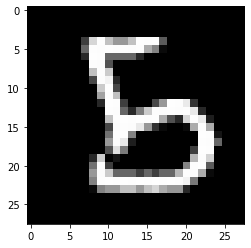

We know it is a: 5
Predicted to be a: 8
0: 0.012%
1: 0.0%
2: 0.004%
3: 0.007%
4: 0.0%
5: 4.175%
6: 2.953%
7: 0.0%
8: 92.813%
9: 0.032%


In [0]:
predictions = model.predict(X_test)
corrects = []
incorrects = []
for i in range(len(predictions)):
  if np.argmax(predictions[i]) == np.argmax(y_test[i]):
    corrects.append(i)
  else:
    incorrects.append(i)

print(f"Percentage Correct: {int(len(corrects) / (len(corrects) + len(incorrects)) * 100000) / 1000.0}%")

index = incorrects[32]
digit = X_test[index]
label = y_test[index]
prediction = model.predict([[digit]])
draw_digit(digit)
print(f"We know it is a: {np.argmax(label)}")
print(f"Predicted to be a: {np.argmax(prediction)}")
print('\n'.join([f'{i}: {int(prediction[0][i] * 100000) / 1000}%' for i in range(len(prediction[0]))]))

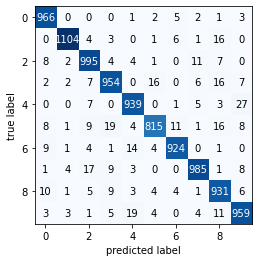

In [0]:
#Confusion Matrix 

predictions = model.predict([X_test])
mod_preds = []
mod_actual = []
for i in range(len(predictions)):
  new_pred = np.argmax(predictions[i])
  new_act = np.argmax(y_test[i])
  mod_preds.append(new_pred)
  mod_actual.append(new_act)

# print (mod_preds)
# print(mod_actual)
cm = confusion_matrix(mod_actual, mod_preds)
fig, ax = plot_confusion_matrix(conf_mat = cm)
plt.show()